# QC script to calculate sharpness metric for images in a plate

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/omero-guide-python/blob/master/notebooks/CalculateSharpnessOneImage.ipynb)

The following script takes an image from the OMERO server.
It adds increasing levels of blurriness to it and then
calculates a 'sharpness' score for the images.
It highlights the start of an investigation for a workflow
that might be used to identify out-of-focus images across
a collection of images.

# Workflow summary

![Overview](SharpnessWorkflow.jpg)

### Install dependencies if required
The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true).

In [ ]:
# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp310-cp310-manylinux_2_28_x86_64.whl
# Package required to interact with IDR or OMERO
%pip install omero-py==5.19.2

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from scipy.ndimage import convolve
import scipy.datasets
from scipy import ndimage
from ipywidgets import widgets
from IPython.display import display

### Create a connection to the OMERO Server

In [2]:
from omero.gateway import BlitzGateway

from getpass import getpass

HOST = 'wss://workshop.openmicroscopy.org/omero-ws'
conn = BlitzGateway(input("Username: "),
                    getpass("OMERO Password: "),
                    host=HOST, secure=True)
conn.connect()

Username:  trainer-1
OMERO Password:  ········


True

### Define the 3 algorithms we are going to test
The algorithms were sourced from:
* gradientBased - [stackoverflow: Detect which image is sharper](https://stackoverflow.com/questions/6646371/detect-which-image-is-sharper/26014796)
* fourierBased - [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
* edgeBased - Canny Edge Detection algorithm scipy

In [3]:
class AlgorithmList:
    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness

    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > M // float(1000)).sum()
        if 'image' in locals():
            sharpness = Th // (float(image.getSizeX()) * float(image.getSizeY()))
            return sharpness*10000
        else:
            return Th

    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness


print("loaded:", dir(AlgorithmList))

loaded: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


### Choose the algorithm to test

In [4]:
def dropdown_widget(Algorithm_list,
                    dropdown_widget_name,
                    displaywidget=False):

    alg_sel = widgets.Dropdown(
        options=Algorithm_list,
        value=Algorithm_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(alg_sel)
    return alg_sel


Algorithm = dropdown_widget(
    ['Gradient', 'Fourier', 'Edge'],
    'Algorithm: ', True
)

# SELECT THE METHOD THEN MOVE TO THE NEXT CELL WITHOUT RUNNING THE CELL AGAIN

Dropdown(description='Algorithm: ', options=('Gradient', 'Fourier', 'Edge'), value='Gradient')

### Example Image from Scipy to test Algorithms
Now create increasing levels of Gaussian blur on an image
obtained from Scipy package.
Calculate the sharpness of the original and blurred images
using the chosen algorithm.

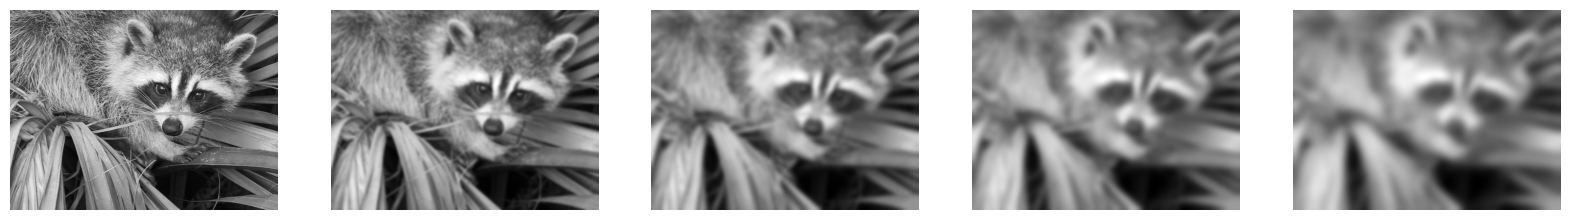

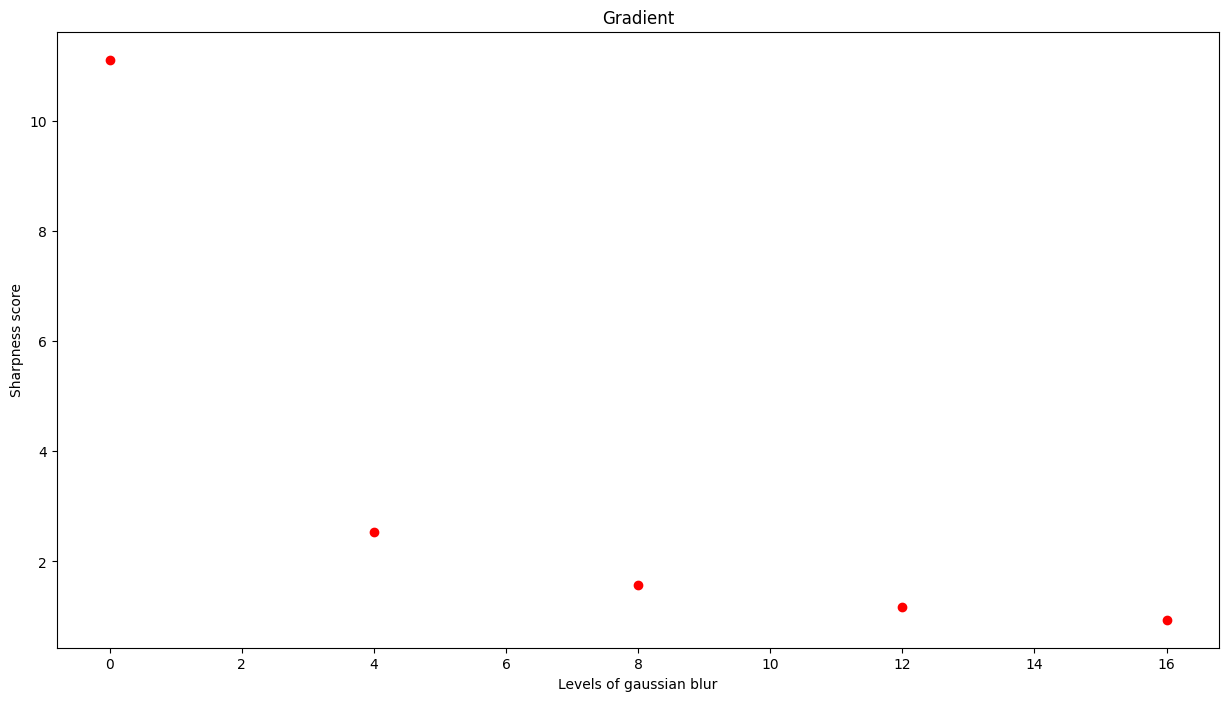

<Figure size 640x480 with 0 Axes>

In [6]:
method = Algorithm.value
if method == 'Gradient':
    sharpness_method = AlgorithmList().gradientBasedSharpnessMetric
elif method == 'Fourier':
    sharpness_method = AlgorithmList().fourierBasedSharpnessMetric
elif method == 'Edge':
    sharpness_method = AlgorithmList().edgeBasedSharpnessMetric

resultArray = np.zeros((5, 2), dtype=float)
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in range(0, 20, 4):
    plane = ndimage.gaussian_filter(scipy.datasets.face(gray=True), sigma=sigValue)
    plt.subplot(1, 5, cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = sharpness_method()
    resultArray[cntr - 1, 1] = sharpness
    resultArray[cntr - 1, 0] = sigValue
    cntr = cntr + 1

plt.show()
plt.figure(figsize=(15, 8))
plt.plot(resultArray[:, 0], resultArray[:, 1], 'ro')
plt.title(method)
plt.xlabel('Levels of gaussian blur')
plt.ylabel('Sharpness score')
plt.show()
plt.gcf().clear()

### Fetch OMERO Image from the server

In [7]:
# ex: Select an Image and enter its Id
imageId = 11270
image = conn.getObject("Image", imageId)
print(image.getName(), image.getDescription())

INMAC384-DAPI-CM-eGFP_59223_1.xdce [Well A-2, Field #1] 


Now create increasing levels of Gaussian blur on an OMERO image.
Calculate the sharpness of the original and blurred images using
the chosen algorithm.

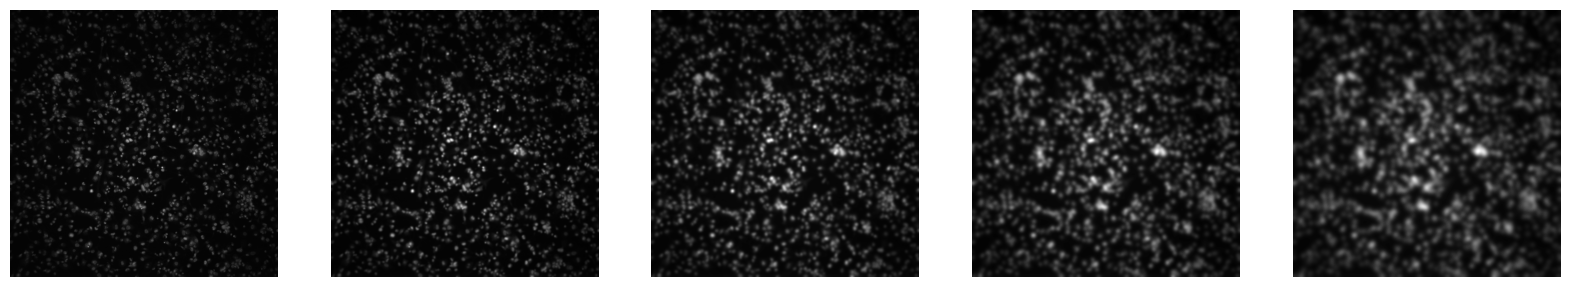

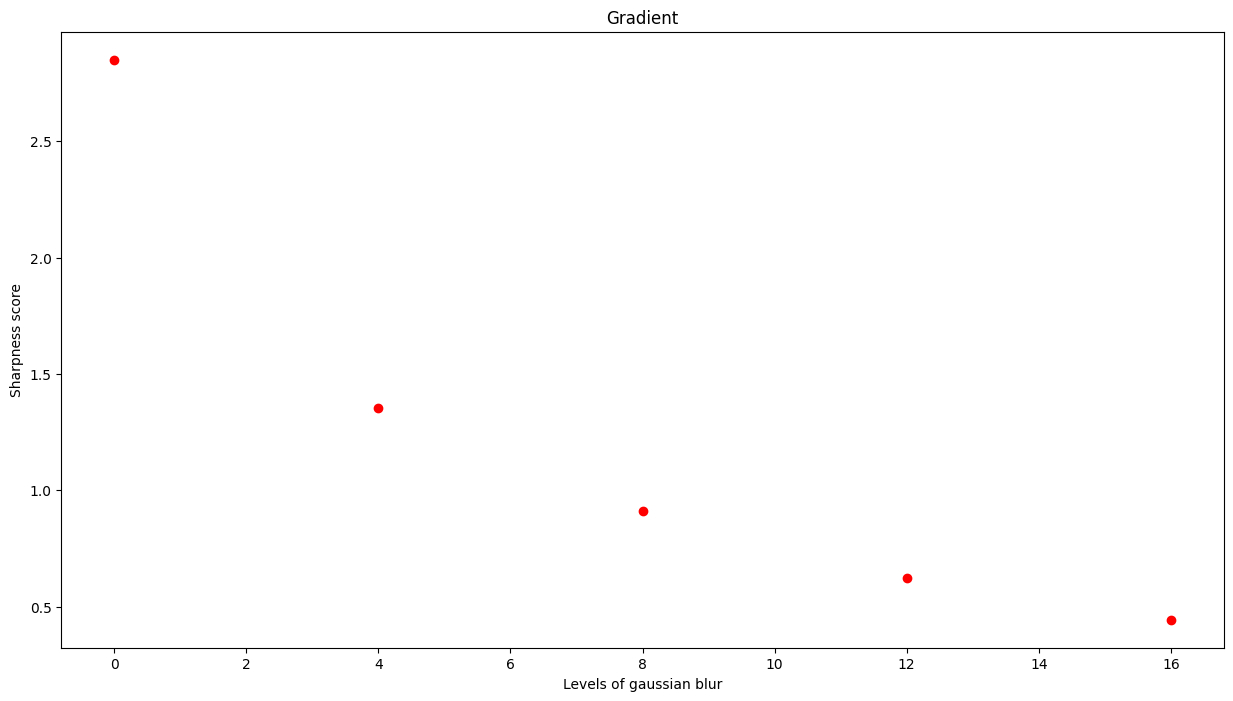

<Figure size 640x480 with 0 Axes>

In [9]:
pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float)
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in range(0, 20, 4):
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1, 5, cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = sharpness_method()
    resultArray[cntr - 1, 1] = sharpness
    resultArray[cntr - 1, 0] = sigValue
    cntr = cntr + 1

plt.show()
plt.figure(figsize=(15, 8))
plt.plot(resultArray[:, 0], resultArray[:, 1], 'ro')
plt.title(method)
plt.xlabel('Levels of gaussian blur')
plt.ylabel('Sharpness score')
plt.show()
plt.gcf().clear()

### Close the connection to the OMERO server

In [10]:
conn.close()

### License (BSD 2-Clause)
Copyright (C) 2019-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.